In [21]:
!gdown --fuzzy 'https://drive.google.com/file/d/19uzLovYrJ_Q0squYfPuKGRo_8m8H6rhl/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=19uzLovYrJ_Q0squYfPuKGRo_8m8H6rhl
To: /kaggle/working/40x.zip
100%|███████████████████████████████████████| 25.3M/25.3M [00:00<00:00, 262MB/s]


In [22]:
import zipfile
import os
def silent_unzip(zip_path,extract_to):

    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
silent_unzip('./40x.zip','yolo')

In [23]:
!pip -q install super-image ultralytics pillow matplotlib opencv-python

In [24]:
!gdown --fuzzy "https://drive.google.com/file/d/1eTqu23L0eJ4VNZvB95lpivYBqYT13oF4/view?usp=sharing"
!gdown --fuzzy "https://drive.google.com/file/d/1RqW4k9r4bfChNyG08hQXVotkIuEOEaxU/view?usp=sharing"
!gdown --fuzzy 'https://drive.google.com/file/d/1kojPlfQqfP7JZqehnnLiuDyICIhOxcbU/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1eTqu23L0eJ4VNZvB95lpivYBqYT13oF4
To: /kaggle/working/1b.jpg
100%|█████████████████████████████████████████| 877k/877k [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RqW4k9r4bfChNyG08hQXVotkIuEOEaxU
To: /kaggle/working/1c.jpg
100%|███████████████████████████████████████| 1.00M/1.00M [00:00<00:00, 125MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1kojPlfQqfP7JZqehnnLiuDyICIhOxcbU
From (redirected): https://drive.google.com/uc?id=1kojPlfQqfP7JZqehnnLiuDyICIhOxcbU&confirm=t&uuid=e437aa21-d15b-4bb3-ae23-f3a4dd584081
To: /kaggle/working/last(dabest)220(2-4).pt
100%|██████████████████████████████████████| 51.3M/51.3M [00:01<00:00, 41.5MB/s]


In [25]:


import os, math, torch, cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Tuple
from ultralytics import YOLO
from super_image import EdsrModel, ImageLoader


IN_20X      = "/kaggle/working/1b.jpg"      # <-- 20× image
YOLO_WEIGHTS= "/kaggle/working/last(dabest)220(2-4).pt"        # <-- your 40×-trained YOLO weights
TILE_20X    = 640                                        # tile size at 20×
OVERLAP     = 0.25                                       # 25% overlap between tiles
IMG_SZ_40X  = 1280                                       # YOLO inference size (match your training)
CONF, IOU   = 0.10, 0.45                                 # detection thresholds


device = 'cuda' if torch.cuda.is_available() else 'cpu'
edsr = EdsrModel.from_pretrained('eugenesiow/edsr-base', scale=2).to(device).eval()  # SR ×2
yolo = YOLO(YOLO_WEIGHTS)  # 40× detector



https://huggingface.co/eugenesiow/edsr-base/resolve/main/pytorch_model_2x.pt


In [26]:
def sliding_windows_fullcover(W:int, H:int, tile:int, overlap:float):
    """
    Yield (x0,y0,x1,y1) windows that fully cover the image.
    Ensures the last tile touches the right/bottom edges even if step doesn't align.
    """
    step = max(1, int(tile * (1 - overlap)))
    xs = list(range(0, max(W - tile, 0) + 1, step))
    ys = list(range(0, max(H - tile, 0) + 1, step))
    if xs[-1] != W - tile:
        xs.append(W - tile)
    if ys[-1] != H - tile:
        ys.append(H - tile)
    for y0 in ys:
        for x0 in xs:
            x1 = min(x0 + tile, W)
            y1 = min(y0 + tile, H)
            yield (x0, y0, x1, y1)

In [27]:

def run_patchwise_sr_yolo(
    in_path:str, tile_20x:int=512, overlap:float=0.25,
    imgsz_40x:int=1024, conf:float=0.1, iou:float=0.45
) -> np.ndarray:
    """
    Returns detections mapped to the ORIGINAL 20× image coordinates:
    array of [x1, y1, x2, y2, conf, class_id]
    """
    base_img = Image.open(in_path).convert("RGB")
    W, H = base_img.size
    detections_20x = []
    
    # --- (A) TILING happens here ---
    for (x0, y0, x1, y1) in sliding_windows_fullcover(W, H, tile_20x, overlap):
        tile_coords.append((x0,y0,x1,y1))
        crop_20x = base_img.crop((x0, y0, x1, y1))

        # --- (B) SUPER-RESOLUTION of the 20× tile to 40×-like (×2) ---
        with torch.no_grad():
            sr_tensor = edsr(ImageLoader.load_image(crop_20x).to(device)).detach().cpu()
        sr = sr_tensor.squeeze(0).clamp(0, 1)                           # [3,H',W']
        sr_np = (sr.permute(1, 2, 0).numpy() * 255).astype(np.uint8)    # H'≈tile*2
        # (Ultralytics can take numpy directly; channel order must be BGR)
        sr_bgr = cv2.cvtColor(sr_np, cv2.COLOR_RGB2BGR)

        # --- (C) YOLO on each SR tile ---
        res = yolo.predict(
            source=sr_bgr, imgsz=imgsz_40x, conf=conf, iou=iou,
            device=0 if torch.cuda.is_available() else 'cpu',
            half=torch.cuda.is_available(), verbose=False
        )[0]

        if res.boxes is None or len(res.boxes) == 0:
            continue

        # --- (D) MAP BACK detections from SR (40×-like) to ORIGINAL 20× coords ---
        # SR is ×2, so divide box coords by 2 to return to the 20× tile space,
        # then offset by (x0,y0) to place in the global 20× canvas.
        for box, confv, clsid in zip(res.boxes.xyxy.cpu().numpy(),
                                     res.boxes.conf.cpu().numpy(),
                                     res.boxes.cls.cpu().numpy()):
            sx1, sy1, sx2, sy2 = box  # SR coords (pixels in the upscaled tile)
            tx1, ty1, tx2, ty2 = sx1 / 2, sy1 / 2, sx2 / 2, sy2 / 2    # back to 20× tile
            gx1, gy1, gx2, gy2 = tx1 + x0, ty1 + y0, tx2 + x0, ty2 + y0 # global 20×
            detections_20x.append([gx1, gy1, gx2, gy2, float(confv), int(clsid)])

    return np.array(detections_20x, dtype=np.float32)

In [28]:
def visualize_tiles(img_path:str, tile_boxes:List[Tuple[int,int,int,int]], out_path:str):
    """Draw red rectangles for each tile on the original 20× image."""
    im = cv2.imread(img_path)
    for (x0,y0,x1,y1) in tile_boxes:
        cv2.rectangle(im, (x0,y0), (x1,y1), (0,0,255), 2)  # red tile box
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    cv2.imwrite(out_path, im)
    return out_path

In [29]:
def draw_boxes_on_image(img_path:str, boxes:np.ndarray, out_path:str):
    """Draw boxes [x1,y1,x2,y2,conf,cls] on the ORIGINAL 20× image and save."""
    im = cv2.imread(img_path)
    for (x1, y1, x2, y2, conf, clsid) in boxes:
        p1 = (int(x1), int(y1)); p2 = (int(x2), int(y2))
        cv2.rectangle(im, p1, p2, (0, 255, 0), 2)
        cv2.putText(im, f"{conf:.2f}", (p1[0], max(0, p1[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    cv2.imwrite(out_path, im)
    return out_path






In [36]:
IN_20X      = "/kaggle/working/yolo/21.11.2025/0001.jpg"

In [37]:
tile_coords = []
boxes20= run_patchwise_sr_yolo(
    IN_20X, tile_20x=TILE_20X, overlap=OVERLAP,
    imgsz_40x=IMG_SZ_40X, conf=CONF, iou=IOU
)

print(f"Detections (20× coords): {boxes20.shape}")
print(f"Tiles generated: {len(tile_coords)}")

Detections (20× coords): (9, 6)
Tiles generated: 8


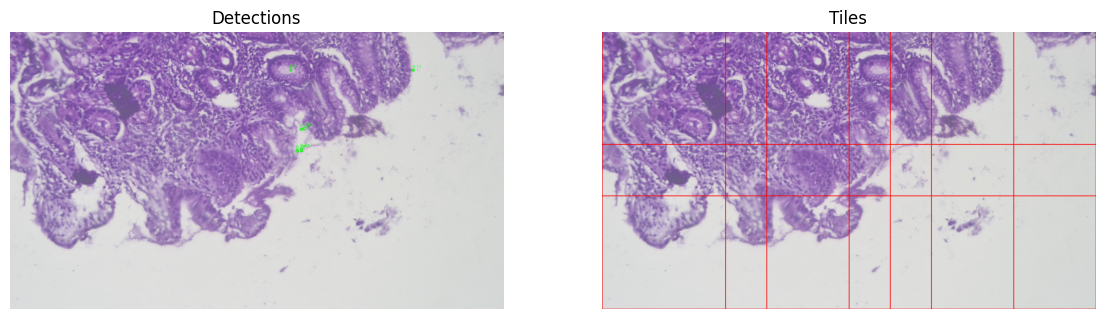

In [38]:
# visualize detections
VIS_OUT = "/kaggle/working/vis_20x_boxes.png"
draw_boxes_on_image(IN_20X, boxes20, VIS_OUT)

# visualize tiles
TILE_OUT = "/kaggle/working/vis_20x_tiles.png"
visualize_tiles(IN_20X, tile_coords, TILE_OUT)

# show side by side
plt.figure(figsize=(14,7))
plt.subplot(1,2,1); plt.imshow(Image.open(VIS_OUT)); plt.axis('off'); plt.title("Detections")
plt.subplot(1,2,2); plt.imshow(Image.open(TILE_OUT)); plt.axis('off'); plt.title("Tiles")
plt.show()

In [39]:

def save_detected_tiles_with_boxes(img_path: str,
                                   boxes: np.ndarray,
                                   tile_boxes: List[Tuple[int,int,int,int]],
                                   out_dir: str):
    """
    Save only those tiles that contain ≥1 detection.
    Draw bounding boxes for detections that fall inside each tile.
    """
    base = cv2.imread(img_path)
    os.makedirs(out_dir, exist_ok=True)
    saved_paths = []

    for idx, (x0,y0,x1,y1) in enumerate(tile_boxes, 1):
        # Get detections overlapping this tile
        dets_in_tile = []
        for (bx1, by1, bx2, by2, conf, clsid) in boxes:
            if not (bx2 < x0 or bx1 > x1 or by2 < y0 or by1 > y1):  # overlap check
                # clip detection to tile boundaries
                cx1 = max(int(bx1 - x0), 0)
                cy1 = max(int(by1 - y0), 0)
                cx2 = min(int(bx2 - x0), x1-x0)
                cy2 = min(int(by2 - y0), y1-y0)
                dets_in_tile.append((cx1, cy1, cx2, cy2, conf, clsid))

        if len(dets_in_tile) == 0:
            continue  # skip tiles without detections

        # Crop tile from base image
        tile_img = base[y0:y1, x0:x1].copy()

        # Draw boxes on the tile
        for (cx1, cy1, cx2, cy2, conf, clsid) in dets_in_tile:
            cv2.rectangle(tile_img, (cx1, cy1), (cx2, cy2), (0,255,0), 2)
            cv2.putText(tile_img, f"{conf:.2f}", (cx1, max(0, cy1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

        # Save
        p = os.path.join(out_dir, f"det_tile_{idx:04d}_{x0}_{y0}_{x1}_{y1}.png")
        cv2.imwrite(p, tile_img)
        saved_paths.append(p)

    return saved_paths


Saved 5 tiles with drawn detections.
Examples: ['/kaggle/working/detected_tiles_with_boxes/det_tile_0002_480_0_1120_640.png', '/kaggle/working/detected_tiles_with_boxes/det_tile_0003_960_0_1600_640.png', '/kaggle/working/detected_tiles_with_boxes/det_tile_0004_1280_0_1920_640.png']


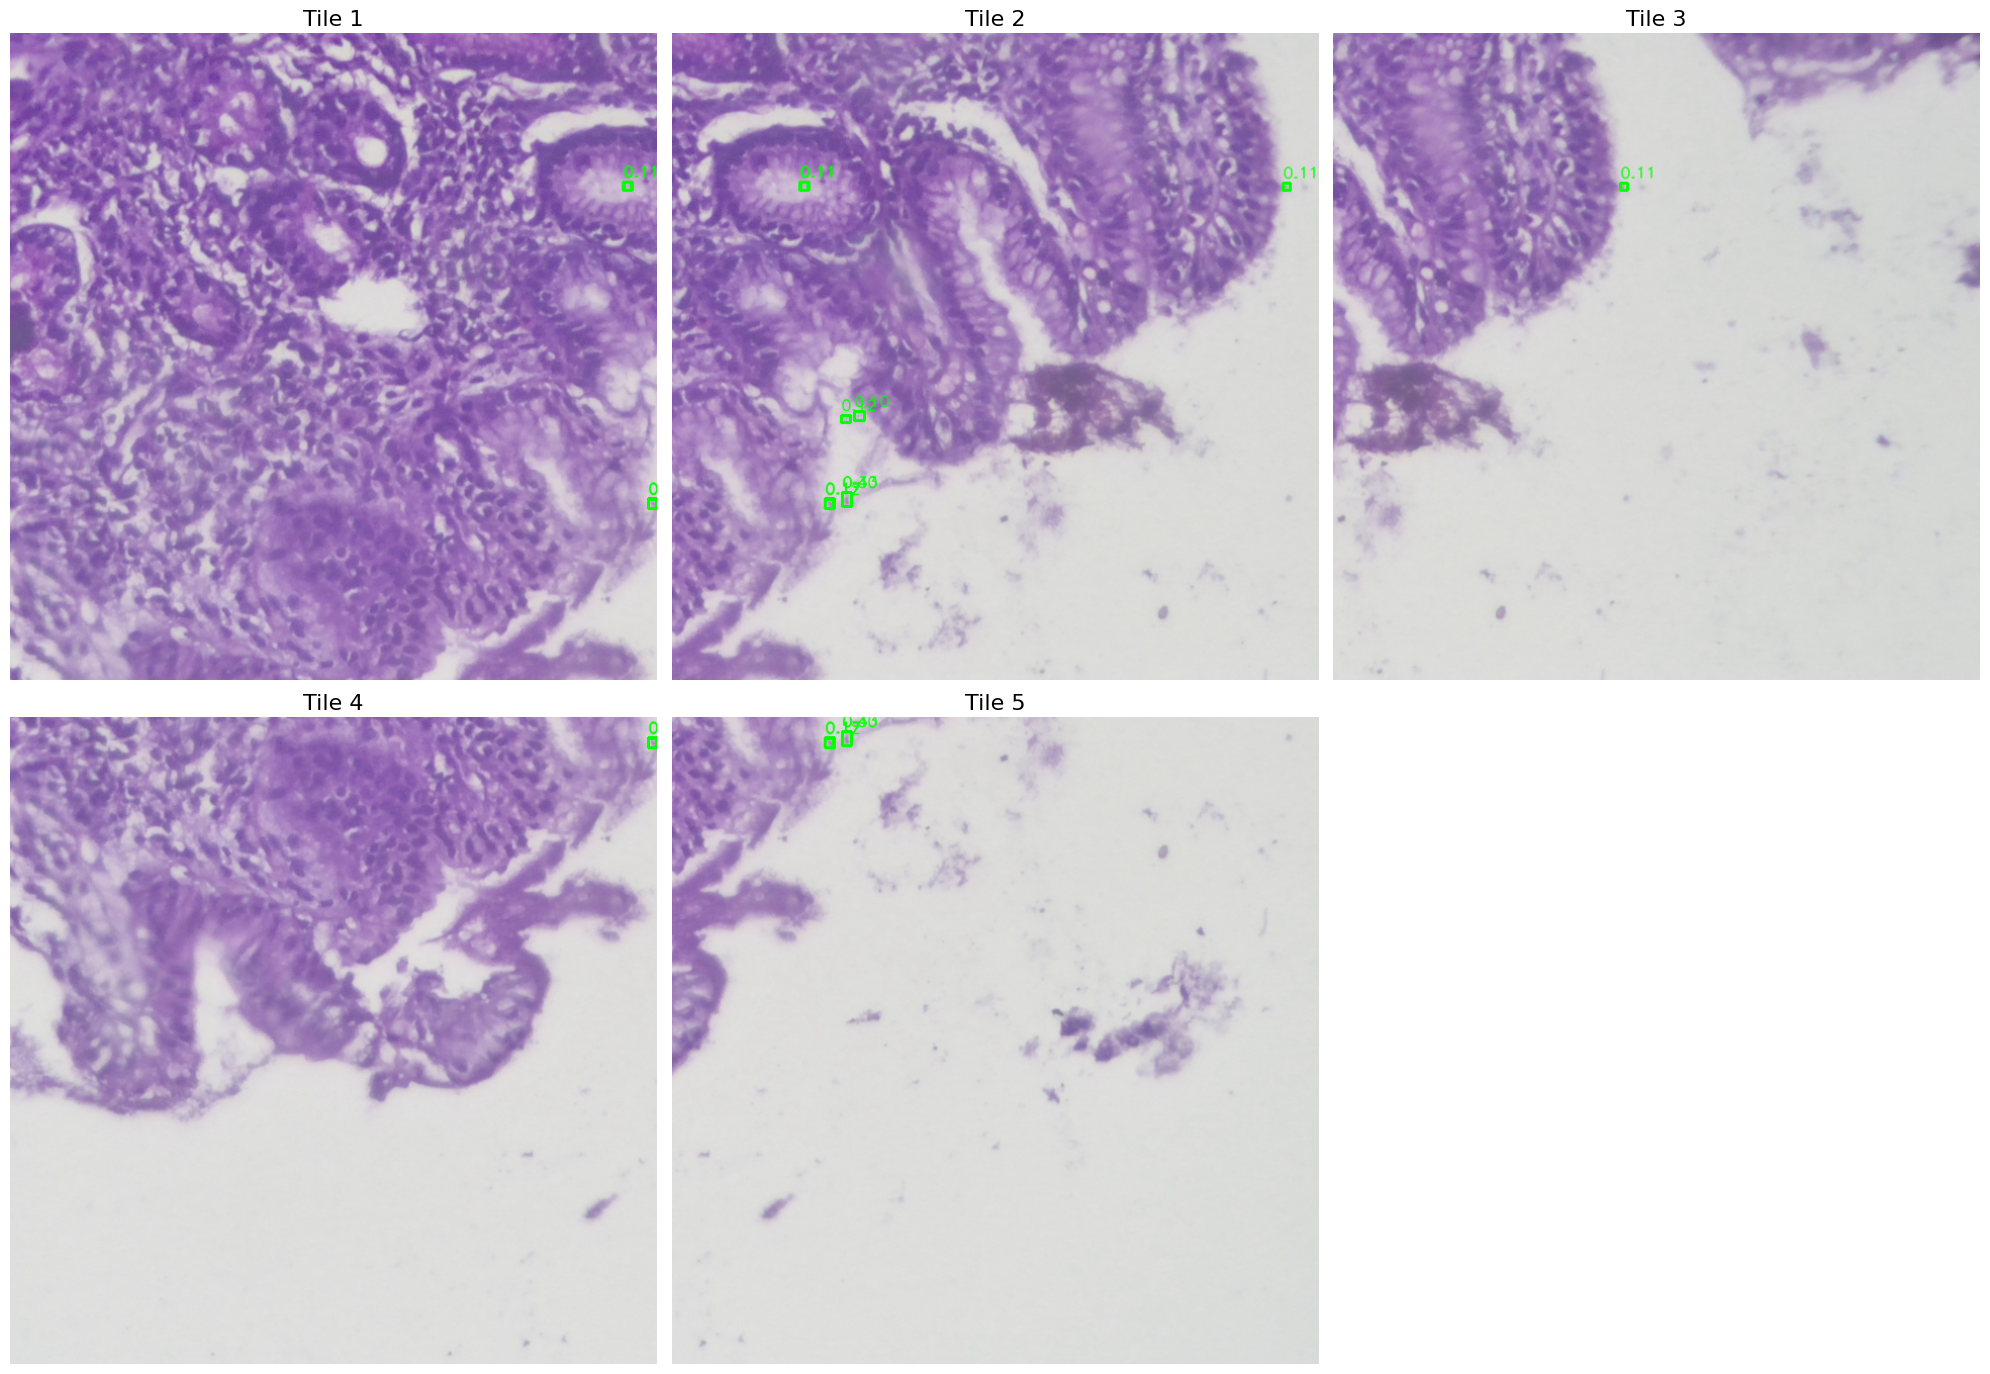

In [40]:
DET_TILES_DIR = "/kaggle/working/detected_tiles_with_boxes"
detected_tiles = save_detected_tiles_with_boxes(IN_20X, boxes20, tile_coords, DET_TILES_DIR)

print(f"Saved {len(detected_tiles)} tiles with drawn detections.")
print("Examples:", detected_tiles[:3])

# Show detected tiles larger in matplotlib
plt.figure(figsize=(20, 14))   # enlarge canvas (width, height in inches)
for i, path in enumerate(detected_tiles[:6], 1):   # show first 6 tiles
    plt.subplot(2, 3, i)
    plt.imshow(Image.open(path))
    plt.axis('off')
    plt.title(f"Tile {i}", fontsize=16)   # bigger font for titles
plt.tight_layout()
plt.show()



In [35]:
import os
import zipfile

folder_path = "/kaggle/working/detected_tiles_with_boxes"
zip_path = "/kaggle/working/detected_tiles_with_boxes.zip"

# Create ZIP file
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)

            # Save inside ZIP with relative path
            arcname = os.path.relpath(file_path, folder_path)
            zipf.write(file_path, arcname)

print("ZIP created:", zip_path)


ZIP created: /kaggle/working/detected_tiles_with_boxes.zip
